# non-parametric Test for Equality of Dispersion
# Median Absolute Deviation (MAD) & Squared-Rank Test
## Example:
## Variability of Snowheight due to Temperature
---

# The Problem

In this example you'll see how the squared-rank test can be applied on climate relevant data. 

This example is about comparing the monthly average snowheights of two periods in the same location.
The two periods differ in the prevailing temperature. Thus the question is, if rising tempertures had a significant impact on the snowcover.
The hypothesis you are testing within this example is:

* $H_0$ : The variability of snow height **does not** vary between Period 1 ad Period 2 $\rightarrow \sigma_x = \sigma_y \rightarrow$ data is **exchangeable** 
* $H_A$ : The variability of snow height **does** vary between Period 1 ad Period 2  $\rightarrow \sigma_x \neq \sigma_y \rightarrow$ data is **not exchangeable** 

To investigate this question, you have to,
* 1.) collect mean monthly snow heights from 1975 to 2015 and split them into two periods
* 2.) calculate the absolute deviation – that is, the absolute difference between the value and the median value – for each season seperately
* 3.) poole both data sets together and rank them
* 4.) seperate them afterwards again, but with their assigned ranks
* 5.) square the ranked values and sum them up to get the sum of the squared ranks for each data set
* 6.) calculate the mean of the sum squared ranks for one of the data sets
* 7.) calculate the variance of the sum squared ranks for the same data set
* 8.) calcualte the continuity correnction for this data set
* 9.) calculate the standardized variable $z$ and compare it with a suitable threshold $z_{\alpha/2}$

You have to decied as followed:
* Reject $H_0$ if $|z| > z_{\alpha/2}$    
* Accept $H_0$ if $|z| < z_{\alpha/2}$  


You can choose between 3 locations: 
* Bodental(995m asl) - filename: SHBodental.csv
* Bärental(987m asl) - filename: SHBärental.csv
* Zell-Pfarre(900m asl) - filename: SHZell.csv

The files can be found in xxxxxxx, to choose one file you'll have to adapt he the filepath in the filename variable.

Variables that can be adapted:
* Month you want to investigate
* length of the periods
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

import statsmodels.api as sm
from scipy.stats import norm

## 1.) collect mean monthly snow heights from 1975 to 2015 and split them into two periods

### To do so,...
### set the file path:

In [2]:
# at first, choose your file
filename1 = '/home/martin/uni/10_Semester/analys_methods_in_climate_science/project/non_parametric_statistics/InitialData/SHBodental.csv'

In [3]:
# set overall lenght, please leave it like this as not all datasets start at this date.
start_date = '1975-01-01'
end_date = '2015-01-01'

# read csv and store it in pd dataframe 
df_1 = pd.read_csv(filename1, sep='\s+', header=1, names = ('Date','Time', 'delim', 'Height'), encoding = "ISO-8859-1")

# make sure that numbers are float not object type
df_1 = df_1.rename(columns={'Height': 'data_1'})
df_1['data_1'] = pd.to_numeric(df_1['data_1'].str.replace(',', '.'))
df_1['Date'] = pd.to_datetime(df_1['Date'], format='%d.%m.%Y')
df_1.set_index('Date', inplace=True)

# filter after predefined period
df_filtered = df_1[start_date : end_date]
df_filtered = df_filtered[["data_1"]]

# resample to monthly frequency
df_monthly = df_filtered.resample('M').mean()

### Set the month you want to investigate
* 1 = January ... 12 = December
* consider that there is no snow in some months! 
* you'll have to change only the variable "monthofinterest"

In [4]:
#select month you want to investigate

monthofinterest = 1

month_name = calendar.month_name[monthofinterest]

df_month_mean = df_monthly.loc[df_monthly.index.month == monthofinterest] # 1 = January... 12 = December
# calculate the monthly mean
df_month_mean = df_month_mean.groupby(df_month_mean.index.year).mean()

### Have a look on the data you selected

<Figure size 1000x500 with 0 Axes>

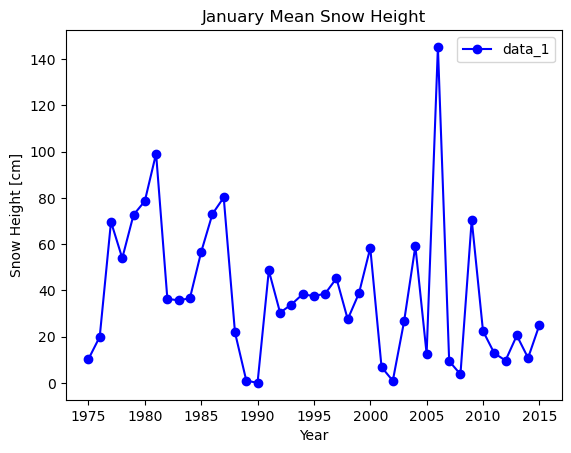

In [5]:
plt.figure(figsize=(10, 5)) #plot data
df_month_mean.plot(kind='line', color='blue',marker='o')
plt.xlabel('Year')
plt.ylabel('Snow Height [cm]')
plt.title(f'{month_name} Mean Snow Height')
plt.legend()
plt.show()

### Next you have to define the lenght of the period and the starting year of each period. 
* the lenght(years) is defined in **"periodlenght"**, shall be a anumber between **5...20**
* the starting year is defined in **"startperiod1 & startperiod2"**, shall be a year between **1975...2015**
* please **consider** that the datasets **end in year 2015**, so the length of the period + the starting year of the latter period shall not exceed 2015

In [6]:
# define period length and start years
periodlength = 20
startperiod1 = 1975
startperiod2 = 1995



# filter original dataframe based on start and end years for each period
df_period1 = df_month_mean[(df_month_mean.index >= startperiod1) & (df_month_mean.index < startperiod1 + periodlength)]
df_period2 = df_month_mean[(df_month_mean.index >= startperiod2) & (df_month_mean.index < startperiod2 + periodlength)]

### In the next plot you can see the 2 periods you want to perform the squared-rank test on

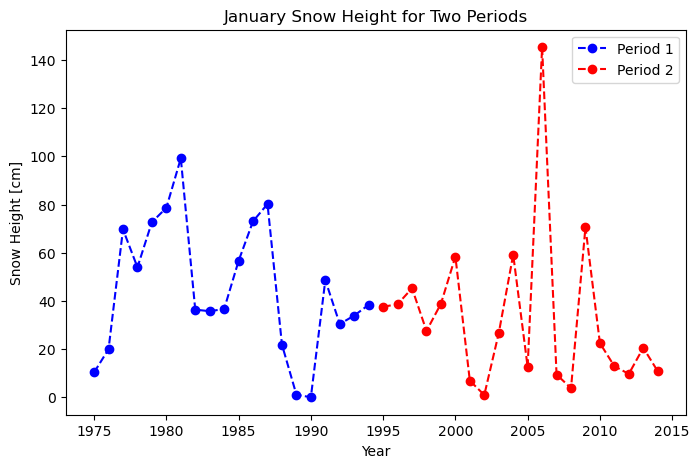

In [7]:
# plot data
plt.figure(figsize=(8, 5))
plt.plot(df_period1.index, df_period1['data_1'], color='blue', linestyle='--', label='Period 1',marker='o')
plt.plot(df_period2.index, df_period2['data_1'], color='red', linestyle='--', label='Period 2',marker='o')
plt.xlabel('Year')
plt.ylabel('Snow Height [cm]')
plt.title(f"{month_name} Snow Height for Two Periods")
plt.legend()
plt.show()

### In the next step we create a combined dataframe of both data sets


In [8]:
# set new index and rename columns
df_period1 = df_period1.reset_index()
df_period1['Date'] = df_period1.index + 1
df_period1 = df_period1.set_index('Date')
df_period2 = df_period2.reset_index()
df_period2['Date'] = df_period2.index + 1
df_period2 = df_period2.set_index('Date')

# merge both df in one frame and set date as index
df_merged = pd.merge(df_period1, df_period2, on=['Date'])

# Rename the columns
df = df_merged.rename(columns={'data_1_x': 'Period_1', 'data_1_y': 'Period_2'})

## 2.) calculate the deviation – that is, the difference between the value and the median value – for each period seperately.
### To do so, calculate the corresponding medians first:
> Its always a good advise to visualize the data

Median of Period_1: 37.483870967741936
Median of Period_2: 24.516129032258064


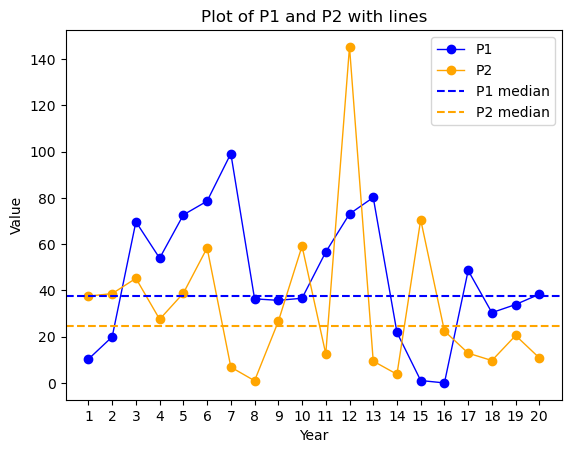

In [9]:
# Calculate the median for each variable
p1_median = df['Period_1'].median()
p2_median = df['Period_2'].median()
print("Median of Period_1:", p1_median)
print("Median of Period_2:", p2_median)

# Create a scatter plot of the data with lines
plt.plot(df.index, df['Period_1'], label='P1', color='blue',marker='o', linestyle='-', linewidth=1)
plt.plot(df.index, df['Period_2'], label='P2', color='orange', marker='o', linestyle='-', linewidth=1)

# Add horizontal lines for medians
plt.axhline(p1_median, color='blue', linestyle='--', label='P1 median')
plt.axhline(p2_median, color='orange', linestyle='--', label='P2 median')

# Add axis labels and a title
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Plot of P1 and P2 with lines')

# Set the x-ticks to only show the year values
plt.xticks(df.index)

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Subtract the corresponding median from each data set to acquire the deviation:

In [10]:
# Create a new dataframe with deviations from respective medians
dev_df = pd.DataFrame({'Period_1': df['Period_1'] - p1_median, 'Period_2': df['Period_2'] - p2_median})

# Print the dataframe
print('Deviations from respective medians:\n')
print(dev_df)
print('\nWith the corresponding medians:\n')
print(dev_df.median().round(2))

Deviations from respective medians:

       Period_1    Period_2
Date                       
1    -27.193548   13.032258
2    -17.548387   14.096774
3     32.193548   20.709677
4     16.451613    3.000000
5     35.193548   14.290323
6     41.129032   33.870968
7     61.677419  -17.677419
8     -1.129032  -23.580645
9     -1.774194    2.064516
10    -0.870968   34.645161
11    19.129032  -11.967742
12    35.580645  120.774194
13    42.709677  -15.096774
14   -15.677419  -20.774194
15   -36.451613   46.064516
16   -37.483871   -2.064516
17    11.129032  -11.645161
18    -7.096774  -14.838710
19    -3.580645   -4.000000
20     0.870968  -13.709677

With the corresponding medians:

Period_1   -0.0
Period_2    0.0
dtype: float64


### Next, form the absolute value to get the absolute deviation:

In [11]:
# Create a new dataframe with the absolute values of the deviations from respective medians
dev_absolute_df = np.abs(dev_df)
print('Absolute values of the deviations from respective medians:\n')
print(dev_absolute_df)
print('\nWith the corresponding medians:\n')
print(dev_absolute_df.median().round(2))

Absolute values of the deviations from respective medians:

       Period_1    Period_2
Date                       
1     27.193548   13.032258
2     17.548387   14.096774
3     32.193548   20.709677
4     16.451613    3.000000
5     35.193548   14.290323
6     41.129032   33.870968
7     61.677419   17.677419
8      1.129032   23.580645
9      1.774194    2.064516
10     0.870968   34.645161
11    19.129032   11.967742
12    35.580645  120.774194
13    42.709677   15.096774
14    15.677419   20.774194
15    36.451613   46.064516
16    37.483871    2.064516
17    11.129032   11.645161
18     7.096774   14.838710
19     3.580645    4.000000
20     0.870968   13.709677

With the corresponding medians:

Period_1    18.34
Period_2    14.56
dtype: float64


Once again, we have calculated the medians of the constructed data set. Since, the data set are the absolute deviations from the mean, you can identify those as the MAD value:
$MAD[X] = median \biggl[ \underbrace{\bigl| X - median[X] \bigr| }_{\Delta X}\biggr]$

If we just apply this formula, one can see that it ends up with the same result: 

In [12]:
# Calculate the MAD for each variable
p1_mad = np.median(np.abs(df['Period_1'] - p1_median))
p2_mad = np.median(np.abs(df['Period_2'] - p2_median))
print("MAD of Period_1:", round(p1_mad,2))
print("MAD of Period_2:", round(p2_mad,2))


MAD of Period_1: 18.34
MAD of Period_2: 14.56


But what does tha MAD value tell us?

Well, it is a robust measure of variability or dispersion of a set of data.

MAD is similar to the standard deviation, but it is less sensitive to outliers and skewed data. This makes it a useful measure of variability in data sets that contain extreme values or are not normally distributed.

But what does us the difference in the MAD values tell us?

Since we have two different MAD values, the variability or dispersion of one data differs from the other. Specifically, the set with the higher MAD value has more variability or dispersion than the set with the lower MAD value.

> Again, visualization often helps to gain a better understanding

MAD of Period_1: 18.34
MAD of Period_2: 14.56


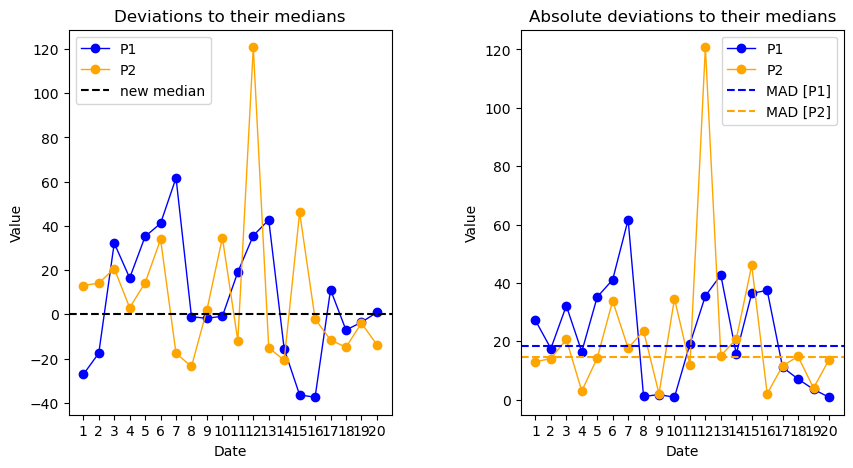

In [13]:
print("MAD of Period_1:", round(p1_mad,2))
print("MAD of Period_2:", round(p2_mad,2))

# create subplot with 2 horizontally aligned plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


# plot the first subplot on ax1
# Create a scatter plot of the deviation data with lines
ax1.plot(df.index, dev_df['Period_1'], label='P1', color='blue',marker='o', linestyle='-', linewidth=1)
ax1.plot(df.index, dev_df['Period_2'], label='P2', color='orange', marker='o', linestyle='-', linewidth=1)

# Add horizontal lines for medians
ax1.axhline(dev_df['Period_1'].median(), color='black', linestyle='--', label='new median')

# Add axis labels and a title
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
ax1.set_title('Deviations to their medians')

# Set the x-ticks to only show the year values
ax1.set_xticks(df.index)

# Add a legend
ax1.legend()


# plot the second subplot on ax2
# Create a scatter plot of the absolute deviation data with lines
ax2.plot(df.index, dev_absolute_df['Period_1'], label='P1', color='blue',marker='o', linestyle='-', linewidth=1)
ax2.plot(df.index, dev_absolute_df['Period_2'], label='P2', color='orange', marker='o', linestyle='-', linewidth=1)

# Add horizontal lines for medians
ax2.axhline(dev_absolute_df['Period_1'].median(), color='blue', linestyle='--', label='MAD [P1]')
ax2.axhline(dev_absolute_df['Period_2'].median(), color='orange', linestyle='--', label='MAD [P2]')

# Add axis labels and a title
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
ax2.set_title('Absolute deviations to their medians')

# Set the x-ticks to only show the year values
ax2.set_xticks(df.index)

# Add a legend
ax2.legend()


# adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# show the plot
plt.show()

## 3.) Pool both data sets together and rank them

In [14]:
rank_df = dev_absolute_df.copy()

# combine the two columns into a single column
combined = rank_df.stack().reset_index()
combined.columns = ['Date', 'Quarter', 'Value']

# calculate the combined ranking
combined['Rank'] = combined['Value'].rank(method='average')
print(combined)

    Date   Quarter       Value  Rank
0      1  Period_1   27.193548  28.0
1      1  Period_2   13.032258  14.0
2      2  Period_1   17.548387  22.0
3      2  Period_2   14.096774  16.0
4      3  Period_1   32.193548  29.0
5      3  Period_2   20.709677  25.0
6      4  Period_1   16.451613  21.0
7      4  Period_2    3.000000   7.0
8      5  Period_1   35.193548  32.0
9      5  Period_2   14.290323  17.0
10     6  Period_1   41.129032  36.0
11     6  Period_2   33.870968  30.0
12     7  Period_1   61.677419  39.0
13     7  Period_2   17.677419  23.0
14     8  Period_1    1.129032   3.0
15     8  Period_2   23.580645  27.0
16     9  Period_1    1.774194   4.0
17     9  Period_2    2.064516   6.0
18    10  Period_1    0.870968   2.0
19    10  Period_2   34.645161  31.0
20    11  Period_1   19.129032  24.0
21    11  Period_2   11.967742  13.0
22    12  Period_1   35.580645  33.0
23    12  Period_2  120.774194  40.0
24    13  Period_1   42.709677  37.0
25    13  Period_2   15.096774  19.0
2

## 4.) Seperate them afterwards again, but with their assigned ranks
In addition, we also calculate the rank sum just to get a feeling for our data

In [15]:
# split the combined column back into separate columns
ranked = combined.pivot(index='Date', columns='Quarter', values='Rank')

# rename the columns with '_rank' suffix
ranked.columns = [col + '_rank' for col in ranked.columns]

# sort the columns in ascending order
ranked = ranked.reindex(sorted(ranked.columns), axis=1)

# display the final DataFrame
print(ranked)

# display the rank sum
print('\nThe sum of the ranks is given by: \n')
print(ranked.sum())

      Period_1_rank  Period_2_rank
Date                              
1              28.0           14.0
2              22.0           16.0
3              29.0           25.0
4              21.0            7.0
5              32.0           17.0
6              36.0           30.0
7              39.0           23.0
8               3.0           27.0
9               4.0            6.0
10              2.0           31.0
11             24.0           13.0
12             33.0           40.0
13             37.0           19.0
14             20.0           26.0
15             34.0           38.0
16             35.0            5.0
17             11.0           12.0
18             10.0           18.0
19              8.0            9.0
20              1.0           15.0

The sum of the ranks is given by: 

Period_1_rank    429.0
Period_2_rank    391.0
dtype: float64


> Again, it is a good advise to visualize the results


The sum of the ranks is given by: 

Period_1_rank    429.0
Period_2_rank    391.0
dtype: float64


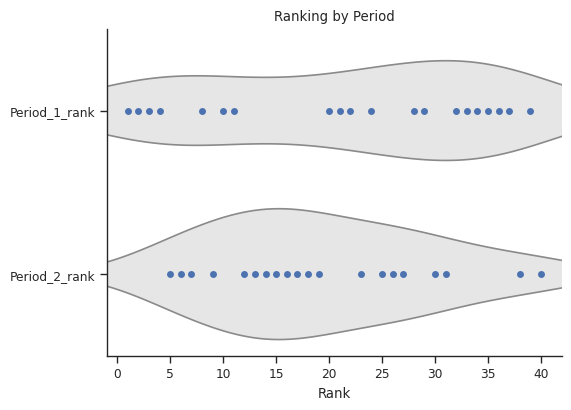

In [16]:
# display the rank sum
print('\nThe sum of the ranks is given by: \n')
print(ranked.sum())

# melt the dataframe to convert the columns into rows
melted_df = ranked.reset_index().melt(id_vars=['Date'], value_vars=['Period_1_rank', 'Period_2_rank'])

# create dot plot using seaborn
sns.set(style="ticks")
sns.set_context("paper")
sns.catplot(x='value', y='variable', kind='violin', data=melted_df, height=4, aspect=1.5, color=".9", inner=None)
sns.swarmplot(data=melted_df, x='value', y='variable', size=5)

# set the x and y labels
plt.xlabel('Rank')
plt.ylabel('')

# set the title
plt.title('Ranking by Period')

# show the plot
plt.show()

## 5.) Square the ranked values and sum them up to get the sum of the squared ranks for each data set

In [17]:
# square each value in the dataframe
squared = ranked**2 

# display the final DataFrame
print(squared)

# sum the squared values
sum_of_squares = squared.sum()  

# display the rank sum
print('\nThe sum of the ranks is given by: \n')
print(sum_of_squares)

      Period_1_rank  Period_2_rank
Date                              
1             784.0          196.0
2             484.0          256.0
3             841.0          625.0
4             441.0           49.0
5            1024.0          289.0
6            1296.0          900.0
7            1521.0          529.0
8               9.0          729.0
9              16.0           36.0
10              4.0          961.0
11            576.0          169.0
12           1089.0         1600.0
13           1369.0          361.0
14            400.0          676.0
15           1156.0         1444.0
16           1225.0           25.0
17            121.0          144.0
18            100.0          324.0
19             64.0           81.0
20              1.0          225.0

The sum of the ranks is given by: 

Period_1_rank    12521.0
Period_2_rank     9619.0
dtype: float64


> Again, visualization!

The sum of the ranks is given by: 

Period_1_rank    12521.0
Period_2_rank     9619.0
dtype: float64


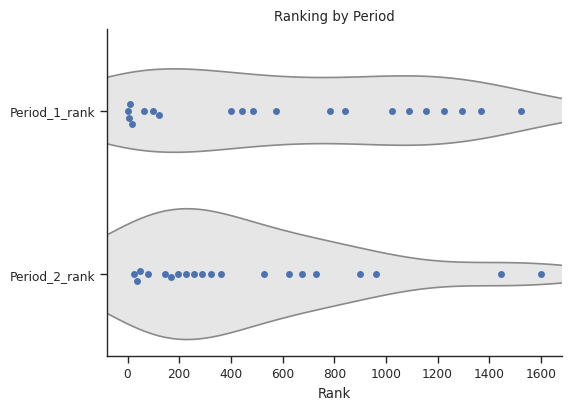

In [18]:
# sum the squared values
sum_of_squares = squared.sum()  

# display the rank sum
print('The sum of the ranks is given by: \n')
print(sum_of_squares)

# melt the dataframe to convert the columns into rows
melted2_df = squared.reset_index().melt(id_vars=['Date'], value_vars=['Period_1_rank', 'Period_2_rank'])

# create dot plot using seaborn
sns.set(style="ticks")
sns.set_context("paper")
sns.catplot(x='value', y='variable', kind='violin', data=melted2_df, height=4, aspect=1.5, color=".9", inner=None)
sns.swarmplot(data=melted2_df, x='value', y='variable', size=5)

# set the x and y labels
plt.xlabel('Rank')
plt.ylabel('')

# set the title
plt.title('Ranking by Period')

# show the plot
plt.show()

## 6.) Calculate the mean (expectaion value) of the sum squared ranks for one of the data sets
> invoking the Central Limit Theorem

In [19]:
# calculate the amount of samples
number_p1 = len(ranked['Period_1_rank'])
number_p2 = len(ranked['Period_2_rank'])
number_total = number_p1 + number_p2

# calculate the expectaion value of the sum square ranks invoking the Central Limit Theorem
expecation_value_sum_of_squared_ranks_p1 = number_p1 * (number_total + 1) * (2 * number_total + 1) / 6
expecation_value_sum_of_squared_ranks_p2 = number_p2 * (number_total + 1) * (2 * number_total + 1) / 6

# display the expectaion value of the sum squared ranks
print("Expectation value of the sum squared ranks regarding Period_1:", expecation_value_sum_of_squared_ranks_p1)

Expectation value of the sum squared ranks regarding Period_1: 11070.0


## 7.) Calculate the variance of the sum squared ranks for the same data set

In [20]:
# Create vector as NumPy array
number_total_count = np.arange(1, number_total+1)

# Calculate result using NumPy functions 
variance_sum_of_squared_ranks_p1 = number_p1 * (number_total - number_p1) / (number_total - 1) * (1 / number_total) * np.sum((number_total_count**2 - (number_total + 1) * (2 * number_total + 1) / 6)**2)
variance_sum_of_squared_ranks_p2 = number_p2 * (number_total - number_p2) / (number_total - 1) * (1 / number_total) * np.sum((number_total_count**2 - (number_total + 1) * (2 * number_total + 1) / 6)**2)

# display the variance of the sum squared ranks
print("Variance of the sum squared ranks regarding Period_1:", variance_sum_of_squared_ranks_p1.round(2))


Variance of the sum squared ranks regarding Period_1: 2442780.0


## 8.) Calcualtes the continuity correnction for this data set

In [21]:
# calculate the continuity correction for each case:
if sum_of_squares['Period_1_rank'] > expecation_value_sum_of_squared_ranks_p1:
    continuity_correction_p1 = -0.5
else:
    continuity_correction_p1 = 0.5
    
if sum_of_squares['Period_2_rank'] > expecation_value_sum_of_squared_ranks_p2:
    continuity_correction_p2 = -0.5
else:
    continuity_correction_p2 = 0.5
    
# display the variance of the sum squared ranks
print("Continuity correction of the sum squared ranks regarding Period_1:", continuity_correction_p1)

Continuity correction of the sum squared ranks regarding Period_1: -0.5


## 9.) Finally, calculate the standardized variable $z$ and compare it with a suitable threshold $z_{\alpha/2}$
> And finds the suitable threshold in the literature

In [22]:
# calculate the standardized statistic
z = (sum_of_squares['Period_1_rank'] - expecation_value_sum_of_squared_ranks_p1 + continuity_correction_p1) / np.sqrt(variance_sum_of_squared_ranks_p1)
print('The standardized statistic variable is: z = ',z.round(2))
pval = norm.sf(abs(z))*2
print('P-value = ',pval.round(3))

# Get 5% critical value for a standard normal distribution - since twotaild use 2.5%
z_alpha = norm.ppf(0.975)

print('The 5% critical value for a normal distribution is: z_alpha/2 = ', z_alpha.round(2))

The standardized statistic variable is: z =  0.93
P-value =  0.353
The 5% critical value for a normal distribution is: z_alpha/2 =  1.96


### Finally, its time for a decision! - you has to decide as followed:
### - Reject $H_0$ if $|z| > z_{\alpha/2}$    
### - Accept $H_0$ if $|z| < z_{\alpha/2}$ 


Since, abs(z) < z_alpha/2, the equal dispersion hypothesis cannot be rejected!


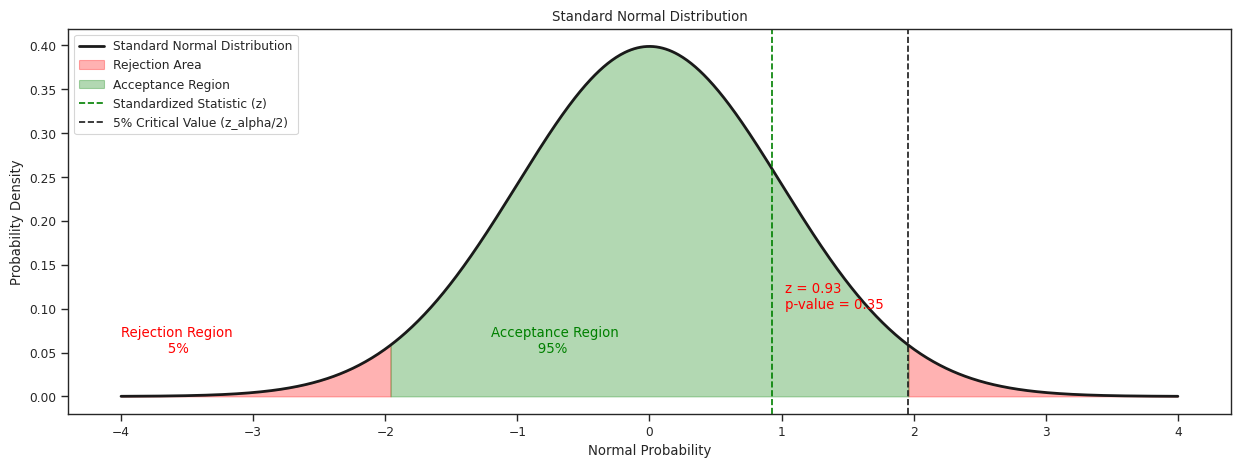

In [23]:
if abs(z) < z_alpha:
    print('\nSince, abs(z) < z_alpha/2, the equal dispersion hypothesis cannot be rejected!')
    z_line_color = 'green'
else:
    print('\nSince, abs(z) > z_alpha/2, the equal dispersion hypothesis has to be rejected!')     
    z_line_color = 'green'

# Generate x values for the normal distribution plot
x = np.linspace(-4, 4, 1000)

# Calculate the y values for the normal distribution plot
y = norm.pdf(x, 0, 1)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the normal distribution curve
ax.plot(x, y, 'k-', linewidth=2, label='Standard Normal Distribution')

# Shade the area corresponding to the right rejection region
x_fill_r = np.linspace(z_alpha, 4, 100)
y_fill_r = norm.pdf(x_fill_r, 0, 1)
ax.fill_between(x_fill_r, y_fill_r, color='red', alpha=0.3, label='Rejection Area')

# Shade the area corresponding to the left rejection region
x_fill_l = np.linspace(-4,-z_alpha, 100)
y_fill_l = norm.pdf(x_fill_l, 0, 1)
ax.fill_between(x_fill_l, y_fill_l, color='red', alpha=0.3)

# Shade the area corresponding to the acceptance region
x_fill_critical = np.linspace(-z_alpha, z_alpha, 100)
y_fill_critical = norm.pdf(x_fill_critical, 0, 1)
ax.fill_between(x_fill_critical, y_fill_critical, color='green', alpha=0.3, label='Acceptance Region')

# Plot the vertical lines for the standardized statistic and critical value
ax.axvline(x=abs(z), color=z_line_color, linestyle='--', label='Standardized Statistic (z)')
ax.axvline(x=z_alpha, color='k', linestyle='--', label='5% Critical Value (z_alpha/2)')

# Set labels and title
ax.set_xlabel('Normal Probability')
ax.set_ylabel('Probability Density')
ax.set_title('Standard Normal Distribution')

# Add legends
ax.legend(loc = 2)

# Add annotations for p-value and critical region
ax.annotate(f'z = {abs(z.round(2))}\np-value = {pval.round(2)}', xy=(abs(z) + 0.1, 0.1), color='red')
ax.annotate(f'Acceptance Region\n           95%', xy=(-1.2, 0.05), color='green')
ax.annotate(f'Rejection Region\n           5%', xy=(-4, 0.05), color='red')

# Show the plot
plt.show()